In [12]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [23]:
filename = "../channel_sol_000015.h5"

with h5py.File(filename, "r") as f:
    print(list(f.keys()))
    a_group_key = list(f.keys())[5]
    print("name of the extracted dataset:", a_group_key)
    # # preferred methods to get dataset values:
    # ds_obj = f[a_group_key]      # returns as a h5py dataset object
    ds_arr = f[a_group_key][()]  # returns as a numpy array
    print("shape of the extracted dataset:", ds_arr.shape)

['iter', 'n1', 'n2', 'n3', 'qcrt', 'qvec', 'sol_snap_number', 'time', 'x', 'y', 'z']
name of the extracted dataset: qvec
shape of the extracted dataset: (6, 600, 300, 1000)


In [34]:
coarse = 10
u = ds_arr[1, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
v = ds_arr[2, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
w = ds_arr[3, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
print(u.shape)

u_fla = u.flatten(order='f')
v_fla = v.flatten(order='f')
w_fla = w.flatten(order='f')
# velocity_field = np.concatenate((u[:,:,:,np.newaxis],v[:,:,:,np.newaxis],w[:,:,:,np.newaxis]), axis=3)
velocity_field_less = np.concatenate((u_fla[:,np.newaxis], v_fla[:,np.newaxis], w_fla[:,np.newaxis]), axis=1)
# velocity_field_less = velocity_field[::5,::5,::5,:]

import numpy as np
import vtk

# Sample data

# Create a vtkImageData object
vtk_data = vtk.vtkImageData()
vtk_data.SetDimensions(u.shape[0], u.shape[1], u.shape[2])

# Flatten the numpy array
flattened_array = velocity_field_less.flatten()
# Create a vtkDoubleArray
vtk_array = vtk.vtkDoubleArray()
vtk_array.SetNumberOfComponents(3)  # Number of components (velocity x, y, z)
vtk_array.SetArray(flattened_array, flattened_array.size, 1)
# Set the vtkDoubleArray as the point data
vtk_data.GetPointData().SetScalars(vtk_array)

# Write the vtkImageData to a VTK file
writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName("velocity_field_coarse.vti")
writer.SetInputData(vtk_data)
writer.Write()

(100, 30, 60)


1

In [35]:
coarse = 5
u = ds_arr[1, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
v = ds_arr[2, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
w = ds_arr[3, ::coarse, ::coarse, ::coarse].transpose([2, 1, 0])
print(u.shape)

u_fla = u.flatten(order='f')
v_fla = v.flatten(order='f')
w_fla = w.flatten(order='f')
# velocity_field = np.concatenate((u[:,:,:,np.newaxis],v[:,:,:,np.newaxis],w[:,:,:,np.newaxis]), axis=3)
velocity_field_less = np.concatenate((u_fla[:,np.newaxis], v_fla[:,np.newaxis], w_fla[:,np.newaxis]), axis=1)
# velocity_field_less = velocity_field[::5,::5,::5,:]

import numpy as np
import vtk

# Sample data

# Create a vtkImageData object
vtk_data = vtk.vtkImageData()
vtk_data.SetDimensions(u.shape[0], u.shape[1], u.shape[2])

# Flatten the numpy array
flattened_array = velocity_field_less.flatten()
# Create a vtkDoubleArray
vtk_array = vtk.vtkDoubleArray()
vtk_array.SetNumberOfComponents(3)  # Number of components (velocity x, y, z)
vtk_array.SetArray(flattened_array, flattened_array.size, 1)
# Set the vtkDoubleArray as the point data
vtk_data.GetPointData().SetScalars(vtk_array)

# Write the vtkImageData to a VTK file
writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName("velocity_field_fine.vti")
writer.SetInputData(vtk_data)
writer.Write()

(200, 60, 120)


1

1

In [ ]:
import vtk
import numpy as np

# Get the input data
input_data = self.GetInputDataObject(0, 0)
point_data = input_data.GetPointData()
velocity_array = point_data.GetArray("Scalars_")

# Convert velocity_array to a NumPy array
velocity_np = np.array(velocity_array)

# Reshape the NumPy array to the original shape
velocity_np = velocity_np.reshape((input_data.GetNumberOfPoints(), 3))
print(velocity_np.shape)

u = velocity_np[:,0].reshape([200,60,120], order='f')
v = velocity_np[:,1].reshape([200,60,120], order='f')
w = velocity_np[:,2].reshape([200,60,120], order='f')


tensor_array = vtk.vtkDoubleArray()
tensor_array.SetNumberOfComponents(6)
tensor_array.SetNumberOfTuples(input_data.GetNumberOfPoints())
box_size = 3
# fortran
counter = 0
for k in range(u.shape[2]):
    z_left  = np.max([0, k-box_size])
    z_right = np.min([u.shape[2], k+box_size])
    for j in range(u.shape[1]):
        y_left  = np.max([0, j-box_size])
        y_right = np.min([u.shape[1], j+box_size])
        for i in range(u.shape[0]):
            x_left  = np.max([0, i-box_size])
            x_right = np.min([u.shape[0], i+box_size])
            temp_u  = u[x_left:x_right, y_left:y_right, z_left:z_right].flatten()
            temp_v  = v[x_left:x_right, y_left:y_right, z_left:z_right].flatten()
            temp_w  = w[x_left:x_right, y_left:y_right, z_left:z_right].flatten()
            temp_data = np.concatenate((temp_u[np.newaxis,:], temp_v[np.newaxis,:], temp_w[np.newaxis,:]), axis=0)
            rey_stress = np.cov(temp_data, bias=True)
            rey_tensor = [rey_stress[0,0], rey_stress[1,1], rey_stress[2,2], rey_stress[0,1], rey_stress[1,2], rey_stress[0,2]]
            tensor_array.SetTuple(counter, rey_tensor)
            counter += 1
point_data.AddArray(tensor_array)
point_data.GetArray("tensors").SetName("Tensors")

In [3]:
# test if it is ideal gas
# for ideal gas: p=rho R T
pt1 = ds_arr[:,1,1,1]
pt2 = ds_arr[:,50,50,50]
pt3 = ds_arr[:,100,80,50]
pt4 = ds_arr[:,500, 200, 800]

# for pt1 
r_1 = pt1[4]/pt1[0]/pt1[5]
r_2 = pt2[4]/pt2[0]/pt2[5]
r_3 = pt3[4]/pt3[0]/pt3[5]
r_4 = pt4[4]/pt4[0]/pt4[5]
print(r_1, r_2, r_3, r_4)

# Yes, it is ideal gas, so we will ignore rho from now on

0.7142857143 0.7142857143 0.7142857143 0.7142857143000001


In [5]:
from numpy import linalg as LA
import math
import random
import time as tt
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import norm
# number of grid points in each dimension
NX = 1000
NY = 300
NZ = 600
# domain length in each dimension
x_len = 16
y_len = 2
z_len = 4
# mesh size in each dimension
x_h = x_len / NX
y_h = y_len / NY
z_h = z_len / NZ
print('mesh size in x direction:', x_h)
print('mesh size in y direction:', y_h)
print('mesh size in z direction:', z_h)

default_spacing = y_h


mesh size in x direction: 0.016
mesh size in y direction: 0.006666666666666667
mesh size in z direction: 0.006666666666666667


In [6]:
def sampleData(x_start=-1, y_start=-1, z_start=-1, np_x=10, np_y=10, np_z=10, \
    x_spacing=1, y_spacing=1, z_spacing=1, test_bool=False):
    '''
    define spatial domain
    '''
    if x_start == -1:
        x_off = random.randint(0, int(NX - np_x*x_spacing)) 
    elif x_start >= 0 and (x_start+np_x*x_spacing) <= NX:
        x_off = x_start
    else:
        raise ValueError('User specified x_start should be in the ' + \
        'range [{0}, {1}]'.format(0,NX-np_x*x_spacing))

    if y_start == -1:
        y_off = random.randint(0, int(NY - np_y*y_spacing)) 
    elif y_start >= 0 and (y_start+np_y*y_spacing) <= NY:
        y_off = y_start
    else:
        raise ValueError('User specified y_start should be in the ' + \
        'range [{0}, {1}]'.format(0,NY-np_y*y_spacing))

    if z_start == -1:
        z_off = random.randint(0, int(NZ - np_z*z_spacing)) 
    elif z_start >= 0 and (z_start+np_z*z_spacing) <= NZ:
        z_off = z_start
    else:
        raise ValueError('User specified z_start should be in the ' + \
        'range [{0}, {1}]'.format(0,NZ-np_z*z_spacing))

    npoints = np_x * np_y * np_z

    data_big = ds_arr[1:, z_off:(z_off+np_z*z_spacing), y_off:(y_off+np_y*y_spacing), x_off:(x_off+np_x*x_spacing)]
    data_small = data_big[:, ::z_spacing, ::y_spacing, ::x_spacing]

    if test_bool:
        print("shape of the whole slice of data array:", data_big.shape)
        print("shape of the useful slice of data array:", data_small.shape)
    # let's find the boundary nodes
    bd_data = np.empty((0,5), float)
    in_data = np.empty((0,5), float)
    for i in range(np_z):
        for j in range(np_y):
            for k in range(np_x):
                current_data_pt = data_small[:,i,j,k]
                if test_bool and i==0 and j==0 and k==0:
                    print("shape of each data points:", current_data_pt.shape)
                if i*j*k==0 or i==9 or j==9 or k==9:
                    bd_data = np.append(bd_data, current_data_pt[np.newaxis, :], axis=0)
                else:
                    in_data = np.append(in_data, current_data_pt[np.newaxis, :], axis=0)

    if test_bool:
        print("shape of boundary data points:", bd_data.shape)
        print("shape of interior data points:", in_data.shape)

    return np.concatenate((bd_data, in_data), axis=0)

def formatData_1(allData, by_type=0):
    '''
    This function is used for an ensemble of RVEs.
    The input allData should be three-dimensional: (num of RVEs, num of points in each RVE, data dimenion for each points)
    
    by_type =0 means data are arranged by type, {u1,u2,...},{v1,v2,...},{w1,w2,...},{p1,p2,...}
    by_type =1 means data are arranged by nodes, {{u1,v1,w1,p1},{u2,v2,w2,p2},...}
    '''
    num_data = allData.shape[1]
    nps = round(num_data**(1/3))
    np_boundary = num_data - (nps-2)**3
    bd_data_temp = np.copy(allData[:, :np_boundary, :])
    if by_type == 0:
        bd_data_temp = np.transpose(bd_data_temp, (0,2,1))
        return np.reshape(bd_data_temp, (allData.shape[0], -1))
    elif by_type == 1:
        return np.reshape(bd_data_temp, (allData.shape[0], -1))
    else:
        raise ValueError("by_type should only by 0 or 1!")

In [6]:
n_samples = 500
nx = 10
ny = 10
nz = 10
n_total_nodes = nx * ny * nz
n_interior_nodes = (nx-2) * (ny-2) * (nz-2)
n_bd_nodes = n_total_nodes - n_interior_nodes
all_data = np.empty((0,n_total_nodes, 5))
for iii in range(10):
    for i in tqdm(range(n_samples)):
        new_data = sampleData(x_start=-1, y_start=-1, z_start=-1, np_x=nx, np_y=ny, np_z=nz)
        #new_plom_data = data4Plom(new_data)
        all_data = np.append(all_data, new_data[np.newaxis, :, :],axis=0)
    print(all_data.shape)

# np.save("sampled_data", all_data)

100%|██████████| 500/500 [00:04<00:00, 117.15it/s]


(500, 1000, 5)


100%|██████████| 500/500 [00:05<00:00, 85.11it/s] 


(1000, 1000, 5)


100%|██████████| 500/500 [00:07<00:00, 71.31it/s]


(1500, 1000, 5)


100%|██████████| 500/500 [00:09<00:00, 55.54it/s]


(2000, 1000, 5)


100%|██████████| 500/500 [00:10<00:00, 47.30it/s]


(2500, 1000, 5)


100%|██████████| 500/500 [00:12<00:00, 39.08it/s]


(3000, 1000, 5)


100%|██████████| 500/500 [00:15<00:00, 32.48it/s]


(3500, 1000, 5)


100%|██████████| 500/500 [00:16<00:00, 30.94it/s]


(4000, 1000, 5)


100%|██████████| 500/500 [00:17<00:00, 28.19it/s]


(4500, 1000, 5)


100%|██████████| 500/500 [00:19<00:00, 25.18it/s]

(5000, 1000, 5)


## start to perform KLE

In [7]:
all_data = np.load('sampled_data.npy')
percentage_test = 0.15
num_training_sample = int((1 - percentage_test) * all_data.shape[0])

bd_data_format = formatData_1(all_data)
print("shape of bd all data:", bd_data_format.shape)
## standardize data
from sklearn.preprocessing import StandardScaler

# initialize StandardScaler
sc = StandardScaler()

# let it figure out means and standard deviations for each 
# feature and use them to standardize the data
sc.fit(bd_data_format)

bd_data_format_std = sc.transform(bd_data_format)

bd_data_test    = np.copy(bd_data_format_std[num_training_sample:, :])
bd_data   = np.copy(bd_data_format_std[:num_training_sample, :])
print("shape of bd training data:", bd_data.shape)
print("shape of bd test data:", bd_data_test.shape)


bd_data_center = bd_data - np.mean(bd_data, axis=0)
covar = np.cov(bd_data_center, rowvar=False)
eig_value, eig_vect = LA.eigh(covar)
dece_EVa = np.flip(eig_value)
dece_EVe = np.flip(eig_vect,1)

shape of bd all data: (5000, 2440)
shape of bd training data: (4250, 2440)
shape of bd test data: (750, 2440)


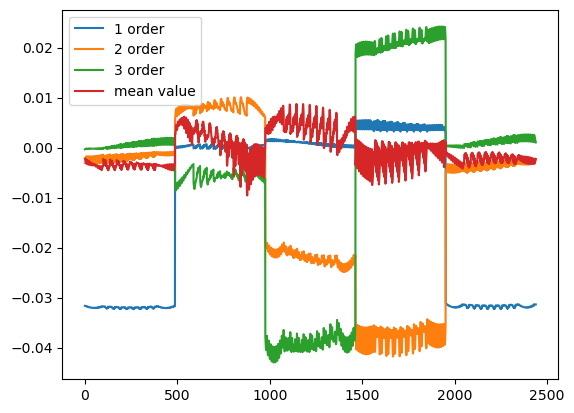

In [24]:
# let's plot the eigen vectors (modes)
# plot the mean of the random field as well
plt.plot(dece_EVe[:,0], label='1 order')
plt.plot(dece_EVe[:,1], label='2 order')
plt.plot(dece_EVe[:,2], label='3 order')
plt.plot(np.mean(bd_data, axis=0), label='mean value')
plt.legend()


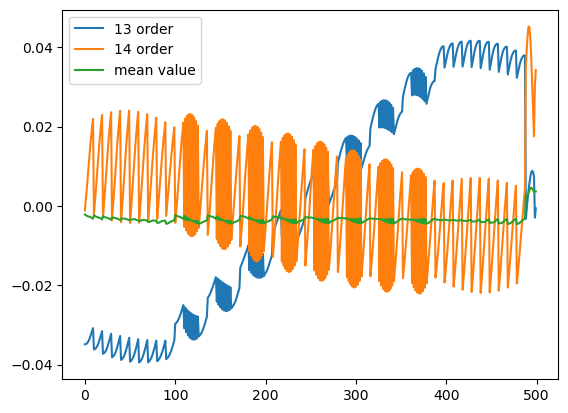

In [14]:
plt.plot(dece_EVe[:500,13], label='13 order')
plt.plot(dece_EVe[:500,14], label='14 order')
plt.plot(np.mean(bd_data, axis=0)[:500], label='mean value')
plt.legend()

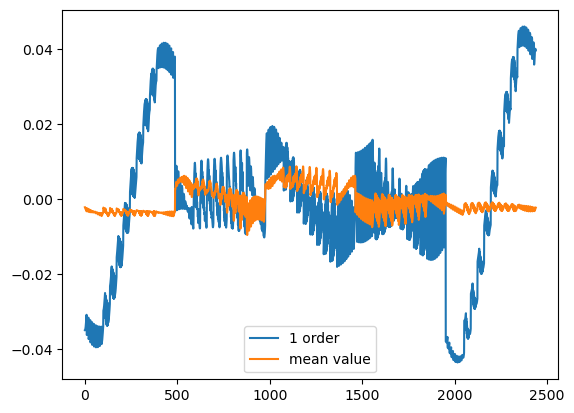

In [10]:
plt.plot(dece_EVe[:,13], label='1 order')

plt.plot(np.mean(bd_data, axis=0), label='mean value')
plt.legend()

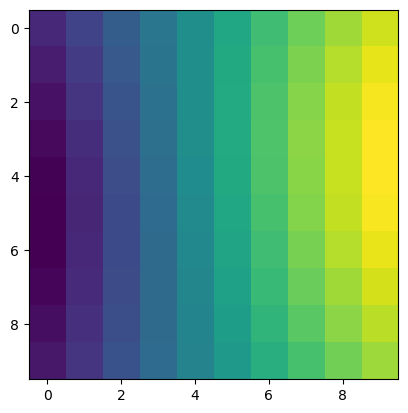

In [33]:
# plot the first 100 points of a eigen vector
# the first 100 points are on the same surface 10*10
u_surface_mode = dece_EVe[:100,14].reshape(10,-1)
plt.imshow(u_surface_mode)
plt.show()


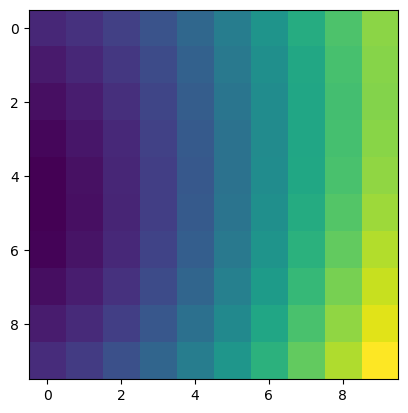

In [32]:
# plot the first 100 points of a eigen vector
# the first 100 points are on the same surface 10*10
u_surface_mode = dece_EVe[:100,1].reshape(10,-1)
plt.imshow(u_surface_mode)
plt.show()


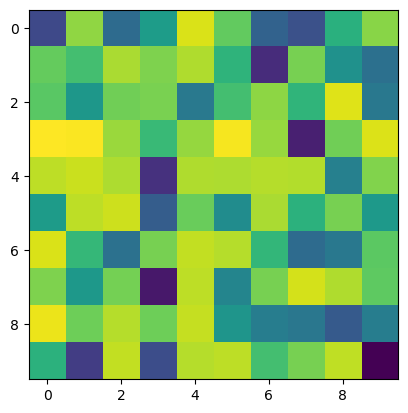

In [43]:
u_surface = bd_data[:100,0].reshape(10,-1)
plt.imshow(u_surface)
plt.show()


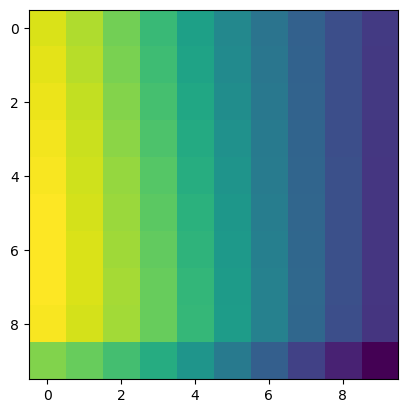

In [42]:
# 488*0-488*1 u components
# 488*1-488*2 v components
# 488*2-488*3 w components
# 488*3-488*4 p components
# 488*4-488*5 T components
# begin-included, end-excluded
begin_pts = 488*3

u_surface = dece_EVe[begin_pts:(begin_pts+100),0].reshape(10,-1)
plt.imshow(u_surface)
plt.show()


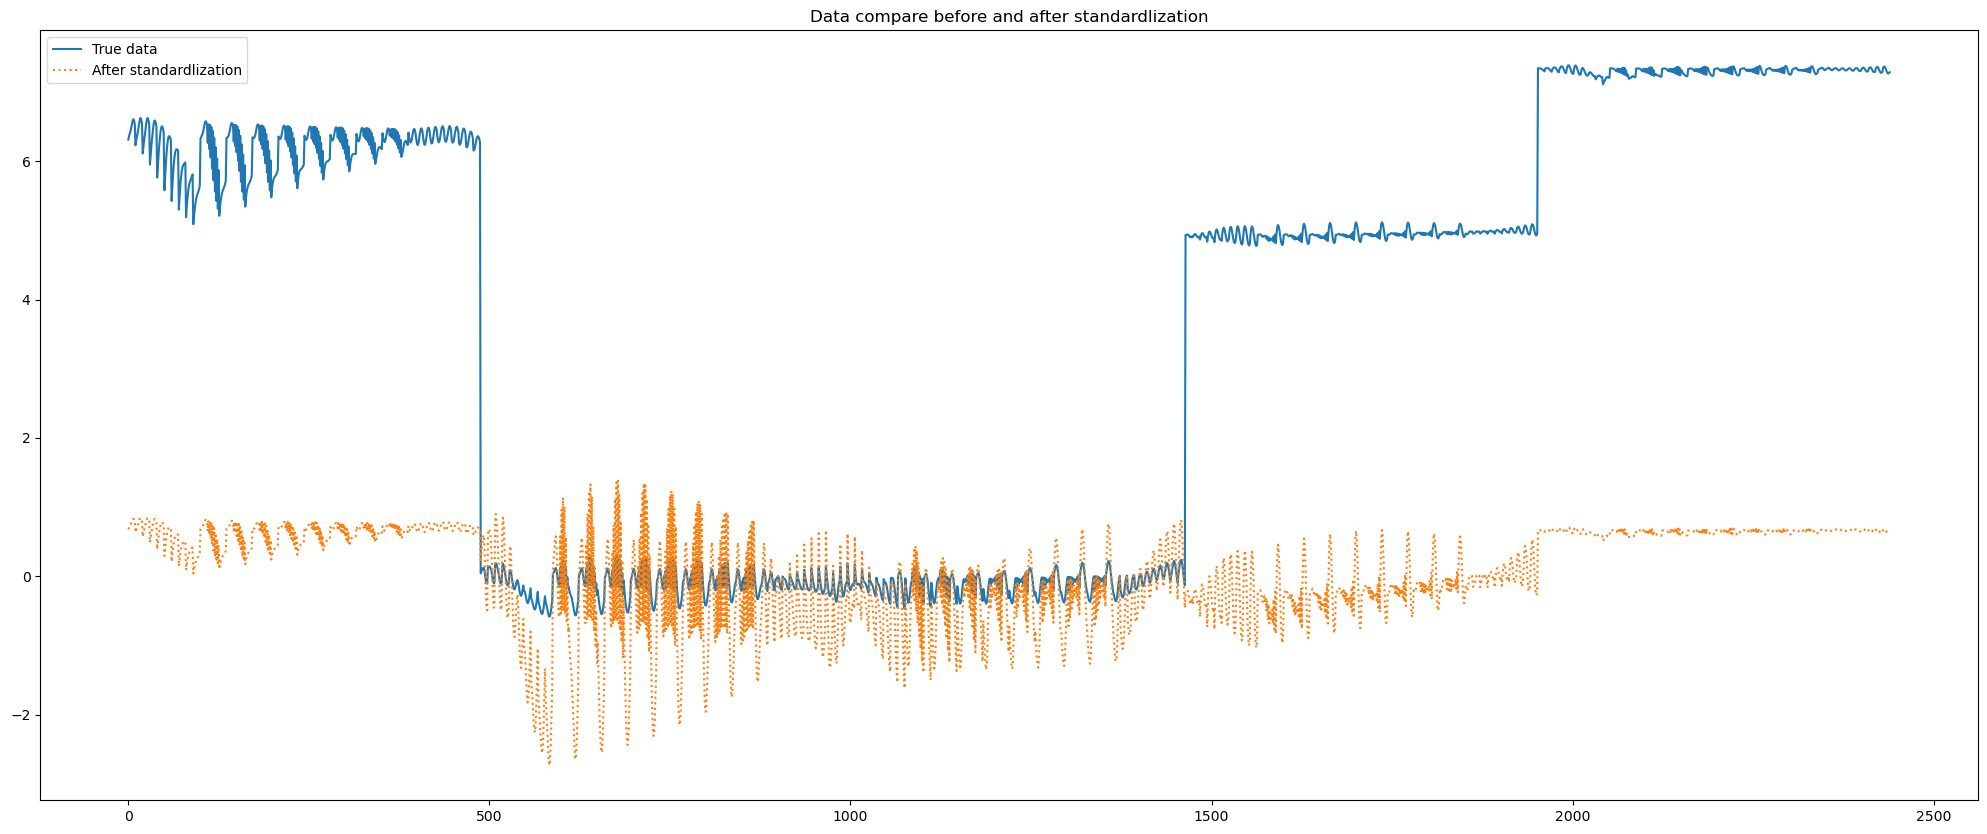

In [10]:
# data compare before and after standardlization
fig = plt.figure(figsize=(25,10))
plt.plot(bd_data_format[1], label="True data")
plt.plot(bd_data_format_std[1], ':',label = "After standardlization")
plt.title("Data compare before and after standardlization")
plt.legend()

[9.27903848e+02 3.98858616e+02 3.68225383e+02 3.49619019e+02
 5.51847736e+01 4.89465809e+01 4.59099893e+01 3.63385600e+01
 2.94687946e+01 2.57370676e+01 1.88381223e+01 1.63037580e+01
 1.53111874e+01 9.95064991e+00 9.62239185e+00 8.15427025e+00
 7.51166144e+00 6.16665190e+00 5.72310591e+00 5.17080998e+00
 4.91588366e+00 4.23712125e+00 3.25373427e+00 2.63513009e+00
 2.44345480e+00 2.15110605e+00 1.95153386e+00 1.86698704e+00
 1.77276170e+00 1.43779429e+00 1.05531455e+00 1.00596722e+00
 9.75352618e-01 9.03125713e-01 8.68501944e-01 8.57868736e-01
 7.90403732e-01 7.51009633e-01 6.88919071e-01 6.48314267e-01]


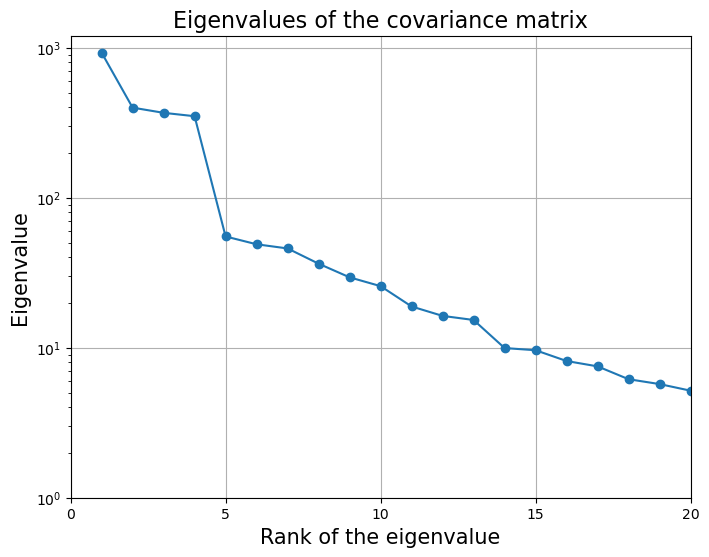

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
show_num_ev = 20
x_axis = np.arange(1,show_num_ev+1)
ax.plot(x_axis, dece_EVa[:show_num_ev], '-o')
ax.set_yscale('log')
ax.set_xlim(0,show_num_ev)
ax.set_title("Eigenvalues of the covariance matrix", fontsize=16)
ax.set_xlabel("Rank of the eigenvalue", fontsize=15)
ax.set_ylabel("Eigenvalue", fontsize=15)
print(dece_EVa[:40])
ax.set_xticks([0,5,10,15,20])
ax.set_yticks([1e3,1e2,1e1,1e0])
ax.grid(':')
with open('eigenValues_25600.txt', 'w') as f:
    for i in range(dece_EVa.size):
        f.write(str(dece_EVa[i]))
        f.write('\n')
plt.savefig('eigen_value_decay_0.04.png',dpi=600 , bbox_inches='tight')

[9.27903848e+02 3.98858616e+02 3.68225383e+02 3.49619019e+02
 5.51847736e+01 4.89465809e+01 4.59099893e+01 3.63385600e+01
 2.94687946e+01 2.57370676e+01 1.88381223e+01 1.63037580e+01
 1.53111874e+01 9.95064991e+00 9.62239185e+00 8.15427025e+00
 7.51166144e+00 6.16665190e+00 5.72310591e+00 5.17080998e+00
 4.91588366e+00 4.23712125e+00 3.25373427e+00 2.63513009e+00
 2.44345480e+00 2.15110605e+00 1.95153386e+00 1.86698704e+00
 1.77276170e+00 1.43779429e+00 1.05531455e+00 1.00596722e+00
 9.75352618e-01 9.03125713e-01 8.68501944e-01 8.57868736e-01
 7.90403732e-01 7.51009633e-01 6.88919071e-01 6.48314267e-01]


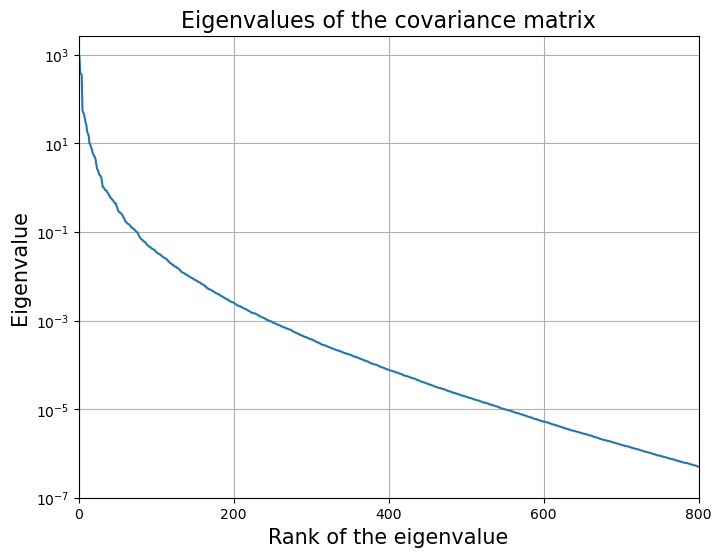

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
show_num_ev = 800
x_axis = np.arange(1,show_num_ev+1)
ax.plot(x_axis, dece_EVa[:show_num_ev])
ax.set_yscale('log')
ax.set_xlim(0,show_num_ev)
ax.set_title("Eigenvalues of the covariance matrix", fontsize=16)
ax.set_xlabel("Rank of the eigenvalue", fontsize=15)
ax.set_ylabel("Eigenvalue", fontsize=15)
print(dece_EVa[:40])
ax.set_xticks([0,200,400,600,800])
ax.set_yticks([1e3,1e1,1e-1,1e-3,1e-5,1e-7])
ax.grid(':')
plt.savefig('eigen_value_decay_0.04_800.png',dpi=600 , bbox_inches='tight')

In [13]:
tot_eigvals = np.sum(dece_EVa)
cumulative_energy = 1.0e-3
for i in range(len(dece_EVa)):
    if np.sum(dece_EVa[0:i])/tot_eigvals > (1-cumulative_energy):
        eigvals_trunc = dece_EVa[:i]
        break
n_eigenvalues = eigvals_trunc.size

print('To acheive {0} accmulative energy, the first {1} eigenvalues are remained.'.format(1-cumulative_energy, n_eigenvalues))

## training data expansion on eigen basis
xi = np.matmul(bd_data_center, dece_EVe[:,:n_eigenvalues])/ np.sqrt(eigvals_trunc)
aaa = np.zeros((n_eigenvalues,n_eigenvalues))
np.fill_diagonal(aaa,np.sqrt(eigvals_trunc))
reconst_value = np.matmul(xi, np.matmul(aaa, dece_EVe[:,:n_eigenvalues].T)) + np.mean(bd_data, axis=0)

resid = bd_data - reconst_value
abso_resid = resid.flatten()
rela_resid = resid.flatten()/(bd_data.flatten()+1e-6)

## test data expansion on eigen basis
bd_data_test_center = bd_data_test - np.mean(bd_data, axis=0)
xi_test = np.matmul(bd_data_test_center, dece_EVe[:,:n_eigenvalues])/ np.sqrt(eigvals_trunc)
bbb = np.zeros((n_eigenvalues,n_eigenvalues))
np.fill_diagonal(bbb,np.sqrt(eigvals_trunc))
reconst_value_test = np.matmul(xi_test, np.matmul(bbb, dece_EVe[:,:n_eigenvalues].T)) + np.mean(bd_data, axis=0)

resid_test = bd_data_test - reconst_value_test

# relative L2 error
relative_l2_error_train = (norm(abso_resid)/norm(bd_data.flatten()))**2
relative_l2_error_test  = (norm(resid_test.flatten())/norm(bd_data_test.flatten()))**2
print("Relative L2 error for training:", relative_l2_error_train)
print("Relative L2 error for test    :", relative_l2_error_test)

To acheive 0.999 accmulative energy, the first 78 eigenvalues are remained.
Relative L2 error for training: 0.0009923446615820388
Relative L2 error for test    : 0.0012767375051783297


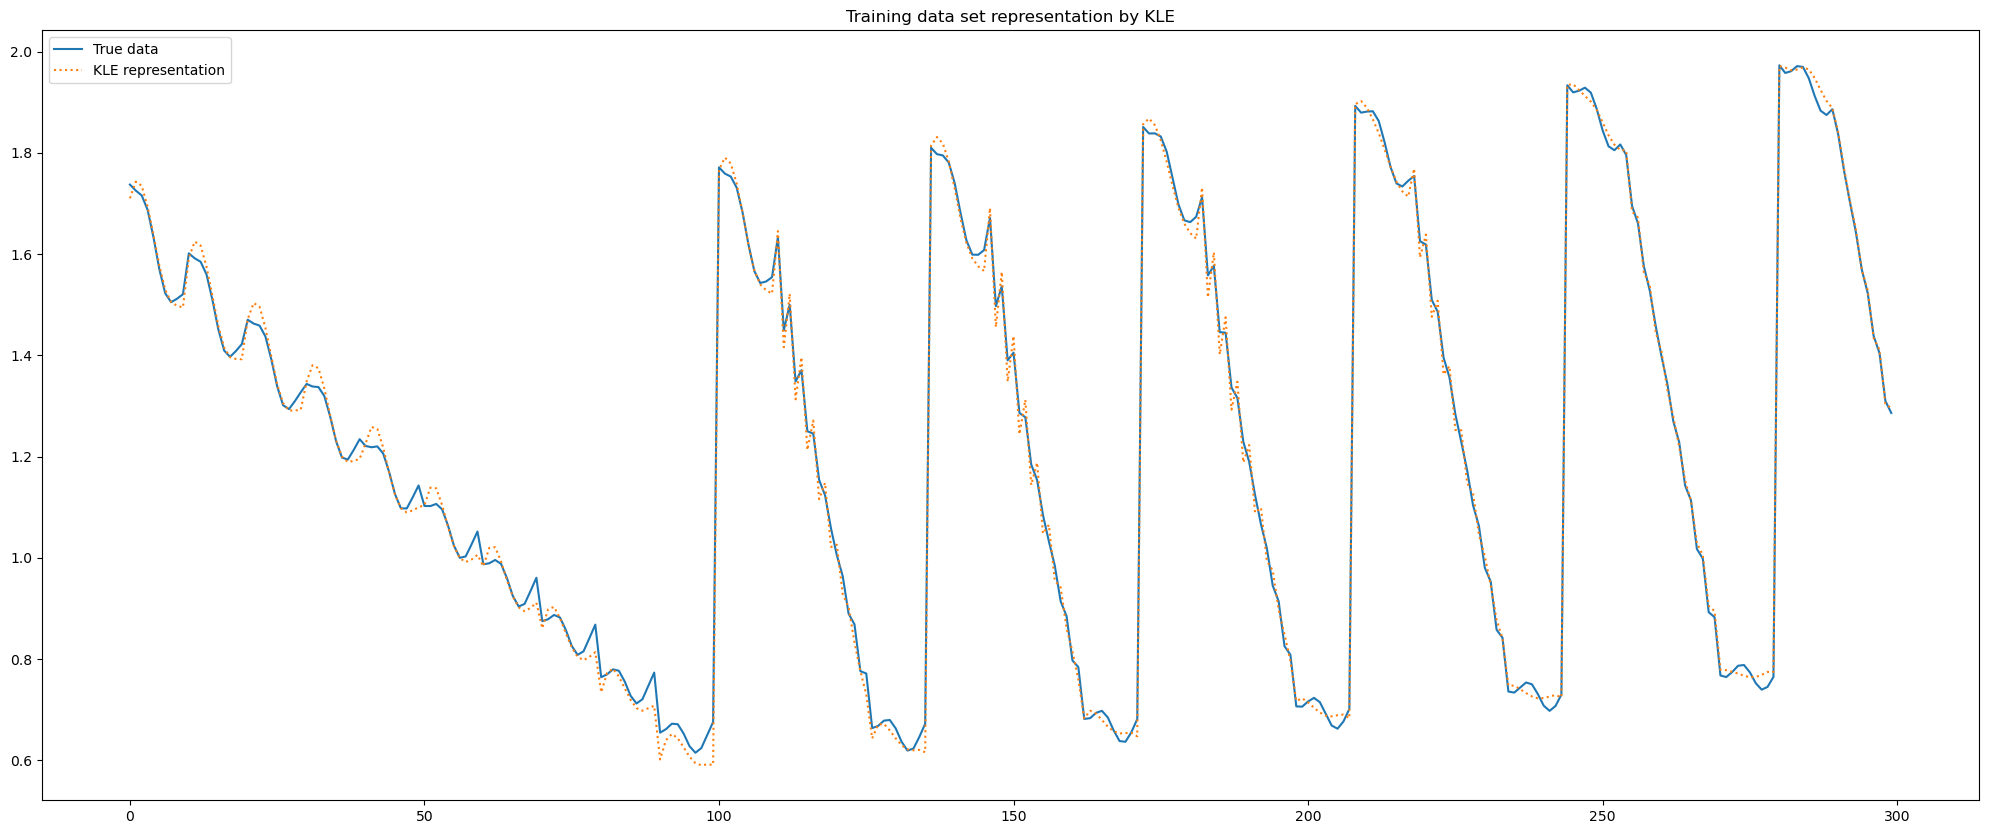

In [14]:
# transform back to the original scale
fig = plt.figure(figsize=(25,10))
plt.plot(bd_data_format[:num_training_sample].flatten()[:300], label="True data")
reconst_value_back = sc.inverse_transform(reconst_value)
plt.plot(reconst_value_back.flatten()[:300], ':',label = "KLE representation")
plt.title("Training data set representation by KLE")
plt.legend()

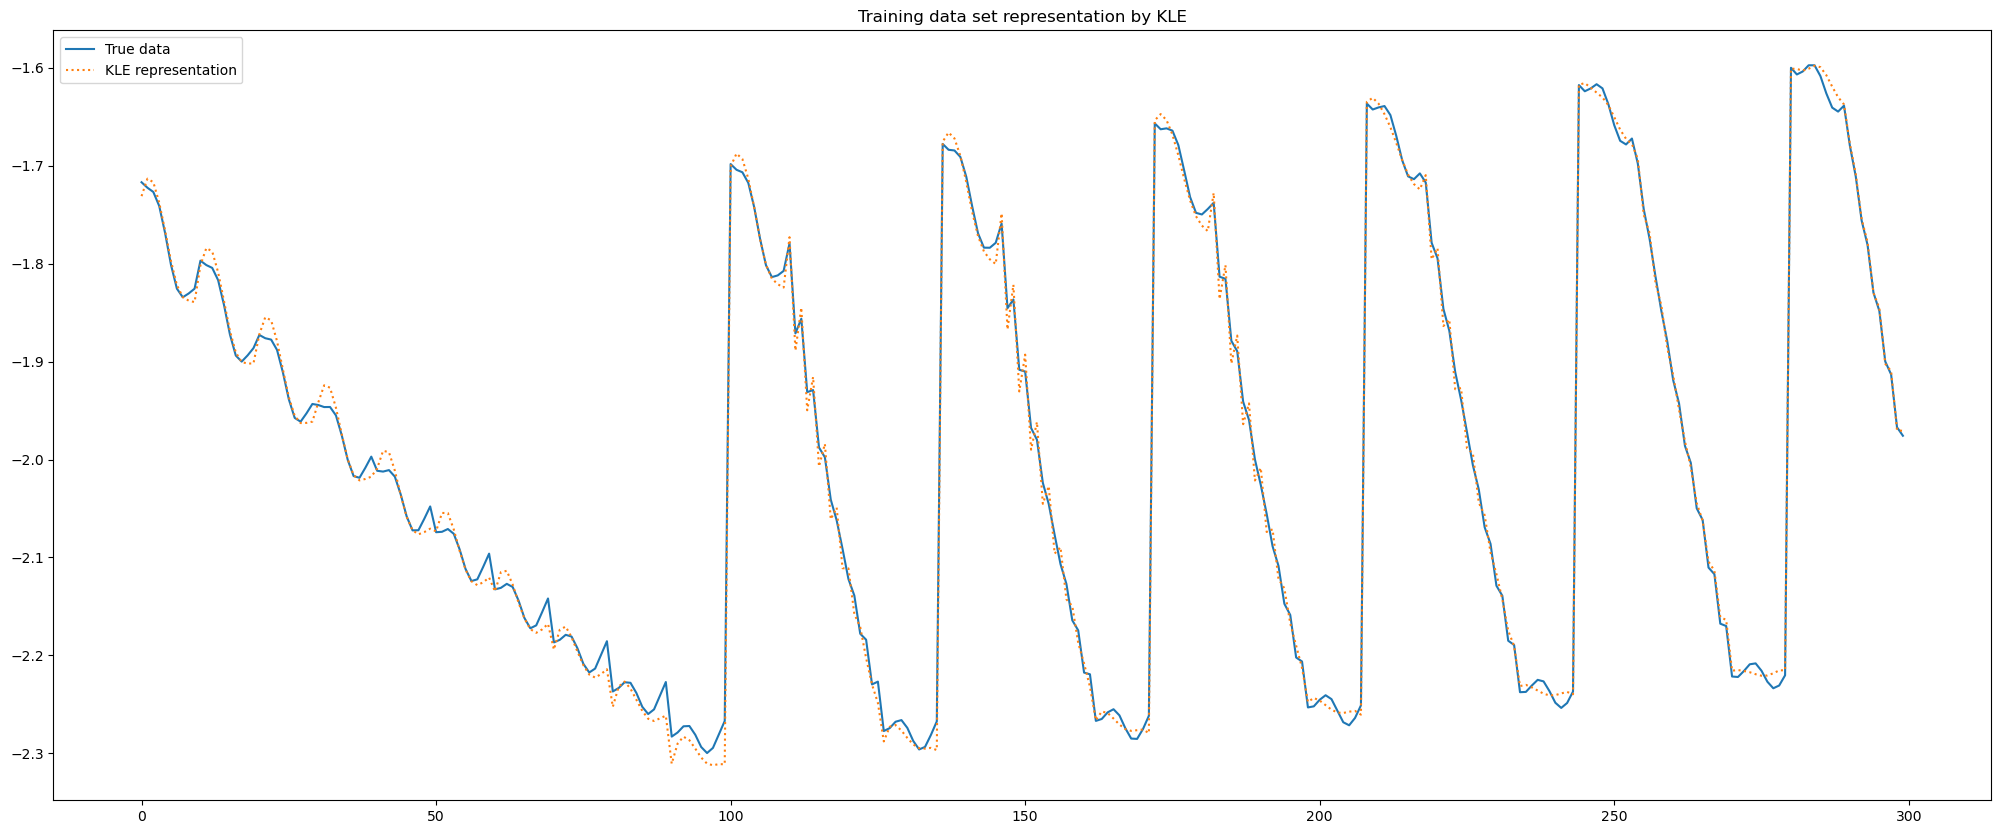

In [15]:
fig = plt.figure(figsize=(25,10))
plt.plot(bd_data.flatten()[:300], label="True data")
plt.plot(reconst_value.flatten()[:300], ':',label = "KLE representation")
plt.title("Training data set representation by KLE")
plt.legend()
# plt.ylim((0,1))

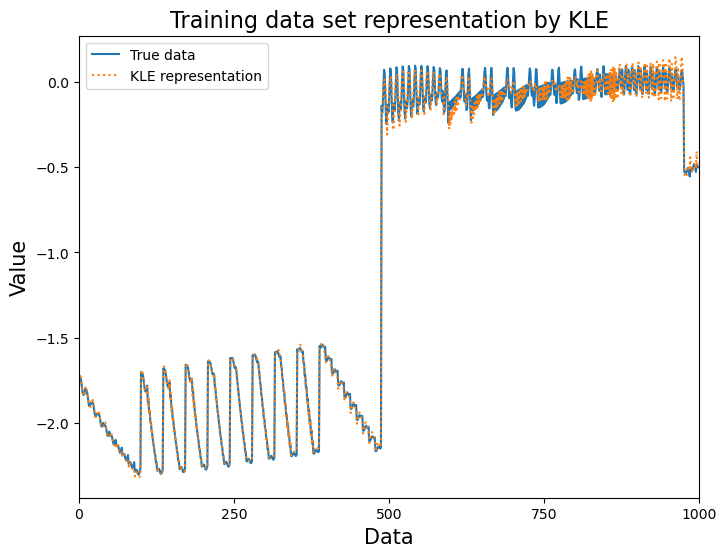

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
show_num_ev = 1000
ax.plot(bd_data.flatten()[:show_num_ev], label="True data")
ax.set_xlim(0,show_num_ev)
ax.plot(reconst_value.flatten()[:show_num_ev], ":",label="KLE representation")
ax.set_title("Training data set representation by KLE", fontsize=16)
ax.set_xlabel("Data", fontsize=15)
ax.set_ylabel("Value", fontsize=15)
ax.set_xticks([0,int(show_num_ev/4),int(show_num_ev/2),int(show_num_ev/4*3),show_num_ev])
# ax.set_yticks([1e2,1e1,1e0,1e-1,1e-2])
plt.legend()
# plt.grid(axis='x')
plt.savefig('kle_representation_trainingdata_iso004.png',dpi=600 , bbox_inches='tight')

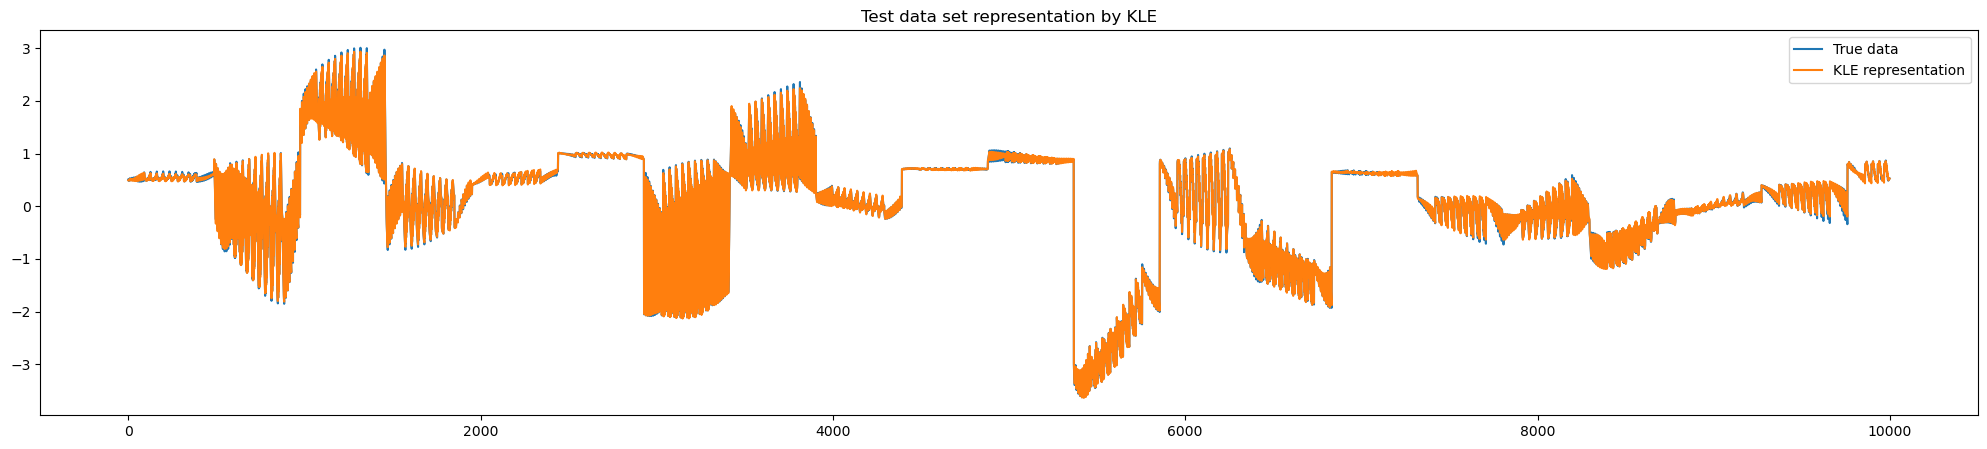

In [17]:
fig = plt.figure(figsize=(25,5))
plt.plot(bd_data_test.flatten()[:10000], label="True data")
plt.plot(reconst_value_test.flatten()[:10000], label = "KLE representation")
plt.title("Test data set representation by KLE")
plt.legend()

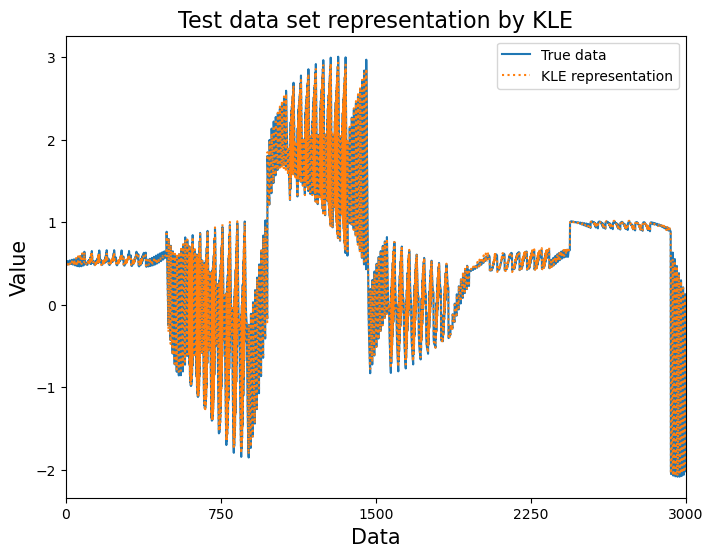

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
show_num_ev = 3000
ax.plot(bd_data_test.flatten()[:show_num_ev], label="True data")
ax.set_xlim(0,show_num_ev)
ax.plot(reconst_value_test.flatten()[:show_num_ev], ":",label="KLE representation")
ax.set_title("Test data set representation by KLE", fontsize=16)
ax.set_xlabel("Data", fontsize=15)
ax.set_ylabel("Value", fontsize=15)
ax.set_xticks([0,int(show_num_ev/4),int(show_num_ev/2),int(show_num_ev/4*3),show_num_ev])
# ax.set_yticks([1e2,1e1,1e0,1e-1,1e-2])
plt.legend()
# plt.grid()
plt.savefig('kle_representation_testdata_iso004.png',dpi=600 , bbox_inches='tight')

/home/zgou/mambaforge3/envs/csci561/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/home/zgou/mambaforge3/envs/csci561/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/home/zgou/mambaforge3/envs/cs

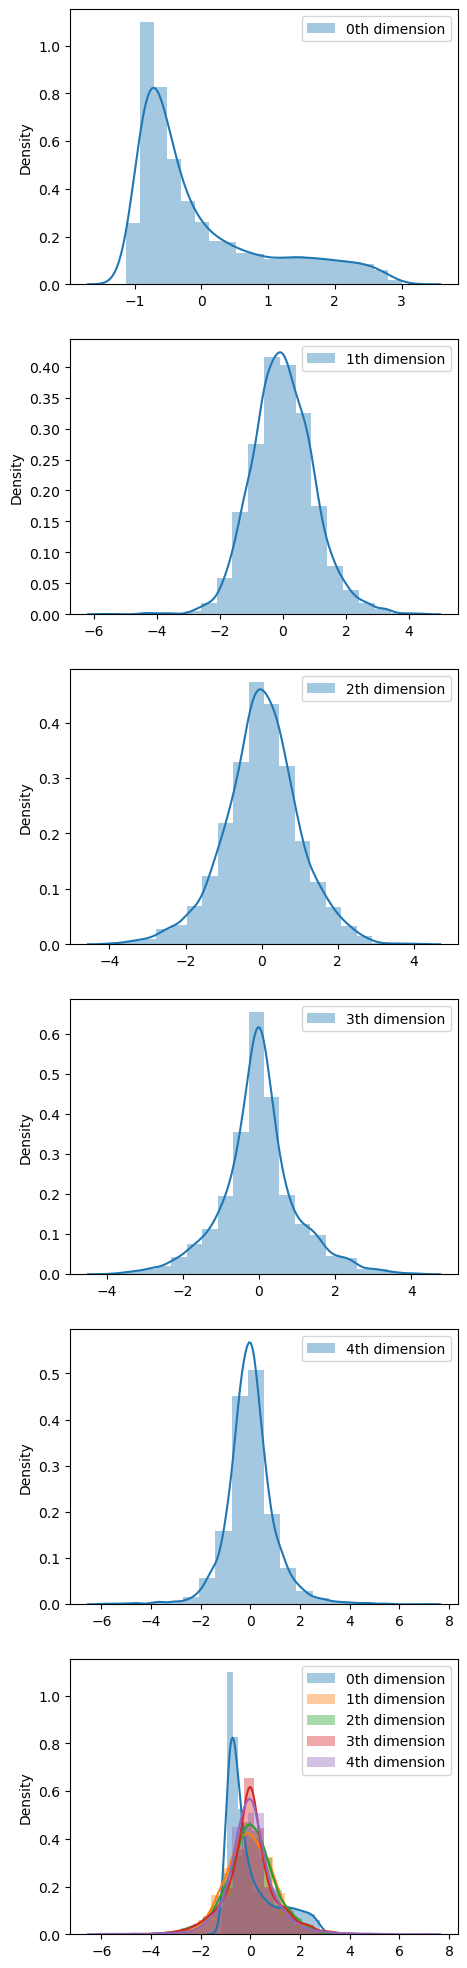

In [22]:
import seaborn as sns
import pandas as pd

n_fig = 5
fig, ax = plt.subplots(n_fig+1, 1, figsize=(5,25))
for i in range(n_fig):
    sns.distplot(ax = ax[i], a = xi[:,i], bins=20, label=str(i)+'th dimension')
    ax[i].legend()

for i in range(n_fig):
    ax[n_fig] = sns.distplot(a = xi[:,i], bins=20, label=str(i)+'th dimension')
    ax[n_fig].legend()

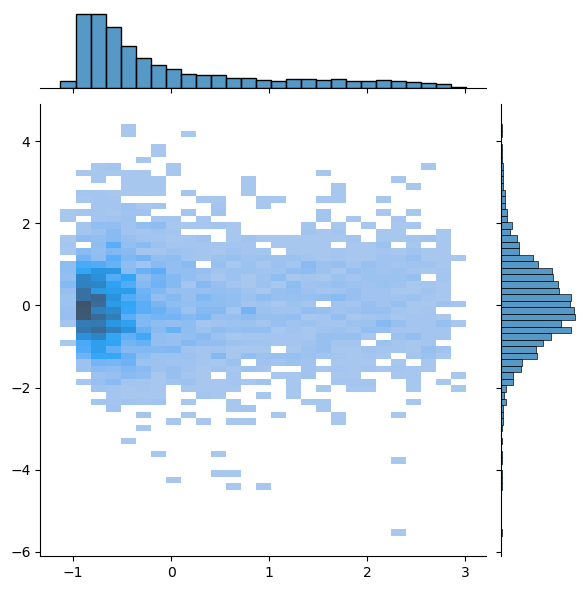

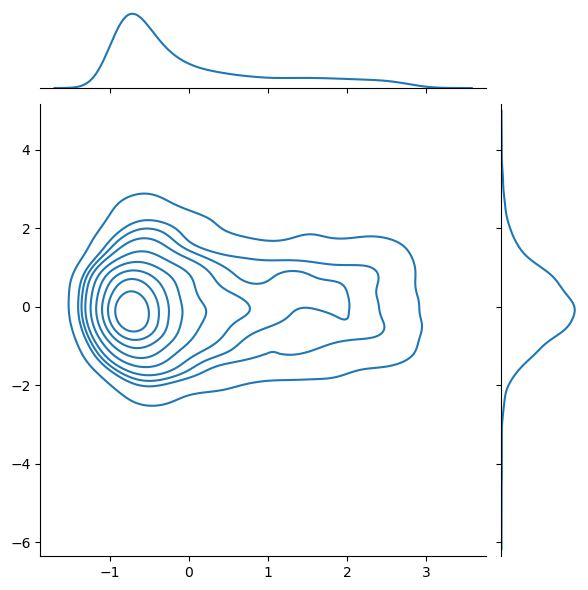

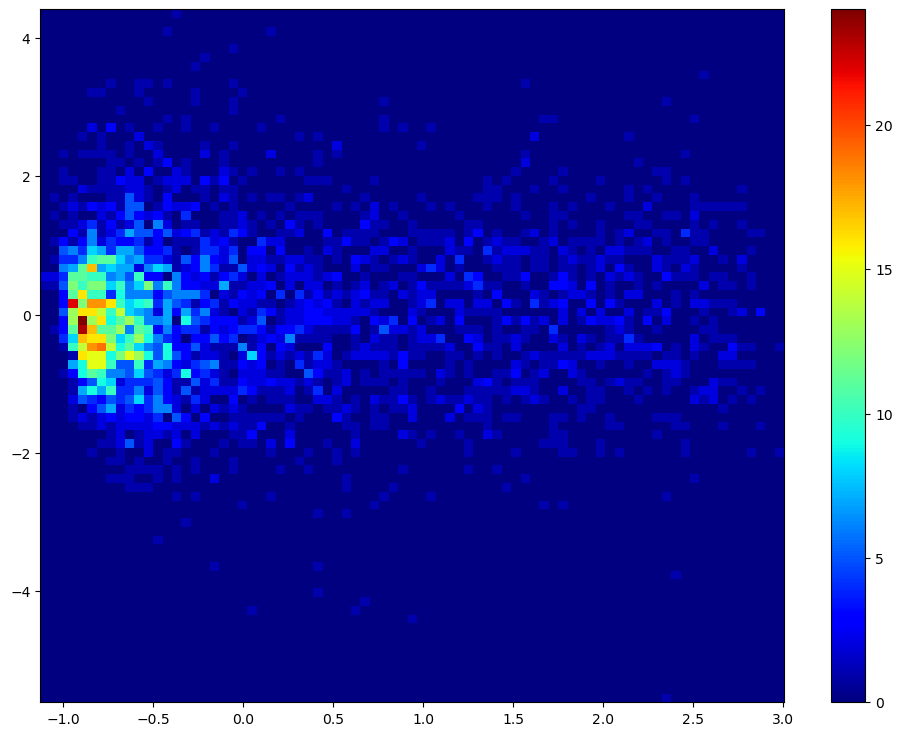

In [23]:
# joint distribution

xixi = np.copy(xi[:,:5])
df = pd.DataFrame(xixi)
sns.jointplot(x=xixi[:,0], y=xixi[:,1], kind="hist")
sns.jointplot(x=xixi[:,0], y=xixi[:,1], kind="kde")

fig = plt.subplots(figsize=(12, 9))
x_bins = np.linspace(np.min(xixi[:,0]), np.max(xixi[:,0]), 80)
y_bins = np.linspace(np.min(xixi[:,1]), np.max(xixi[:,1]), 80)
plt.hist2d(xixi[:,0], xixi[:,1], bins=[x_bins, y_bins], cmap=plt.cm.jet) 
plt.colorbar()

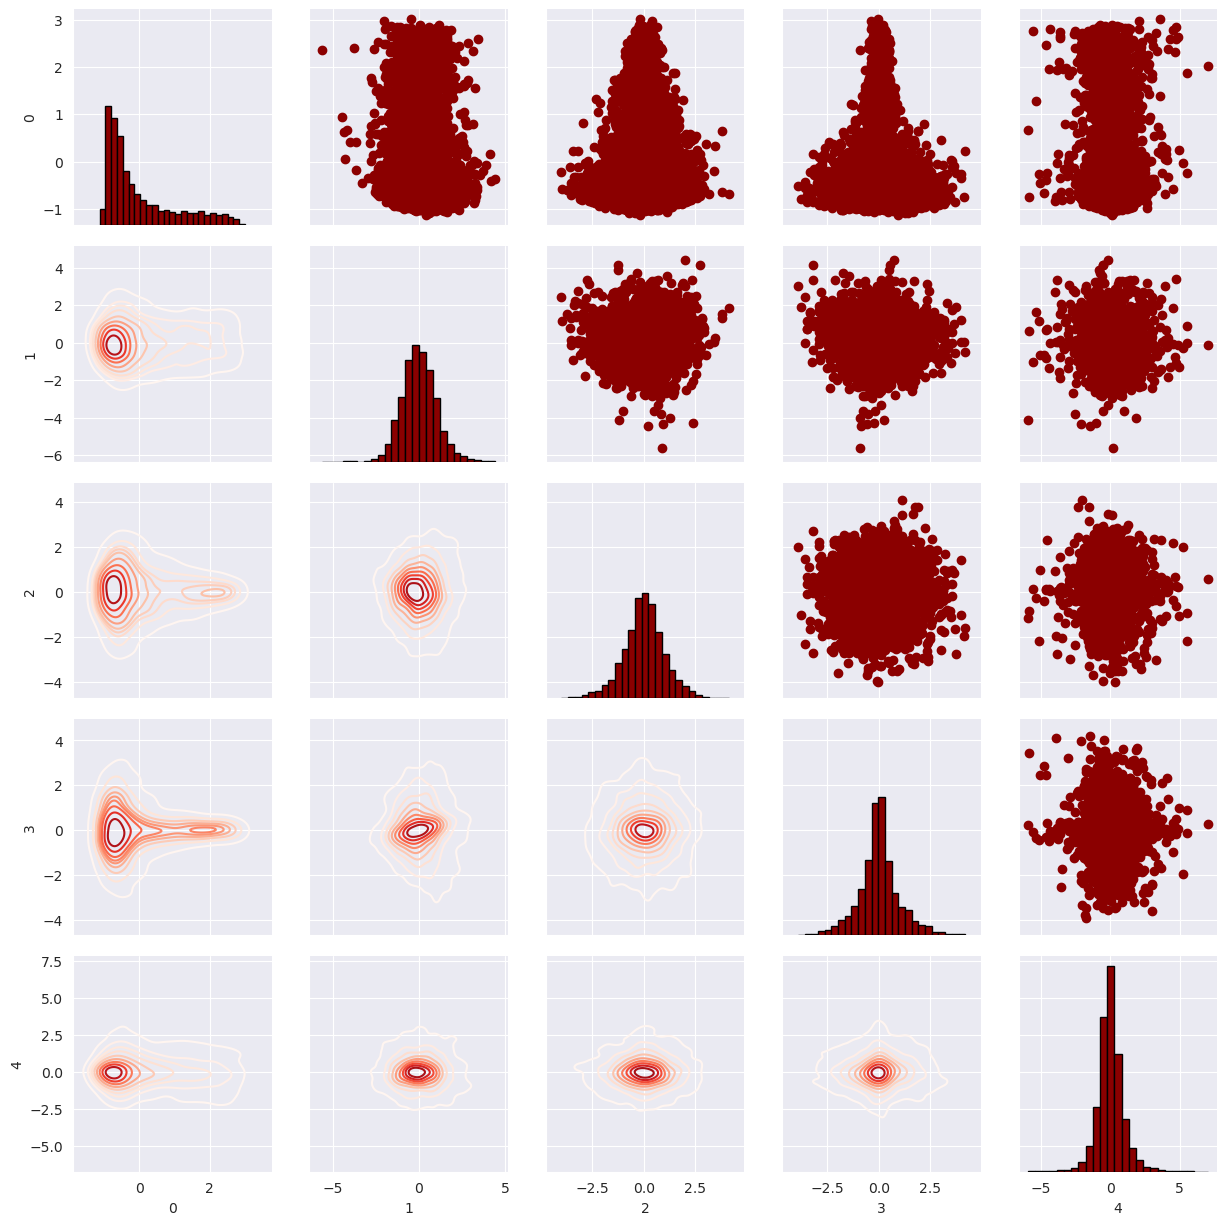

In [24]:
sns.set_style('darkgrid')
grid = sns.PairGrid(df)

grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_diag(plt.hist, bins = 25, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
plt.savefig('pairplot.png',dpi=600 , bbox_inches='tight')

### define QoI

Reyolds stress
$$
\mathbf{\tau}=
\begin{bmatrix}
\overline{u'u'} & \overline{u'v'} & \overline{u'w'} \\
\overline{v'u'} & \overline{v'v'} & \overline{v'w'} \\
\overline{w'u'} & \overline{w'v'} & \overline{w'w'}
\end{bmatrix}
$$

Turbulence kinetic energy (TKE) is defined as:
$$
k=\frac{1}{2}(\overline{(u')^2}+\overline{(v')^2}+\overline{(w')^2})
$$

We also have:
$$
\mathbf{\tau}=2k(\frac{1}{3}\mathbf{I}+\mathbf{A})=2k(\frac{1}{3}\mathbf{I}+\mathbf{V}\mathbf{\Lambda}\mathbf{V}^T)
$$
where $\mathbf{\Lambda}=diag[\lambda_1,\lambda_2,\lambda_3]$ 

In [25]:
u_component = all_data[:,:,0]
v_component = all_data[:,:,1]
w_component = all_data[:,:,2]

print(all_data.shape)
um=np.mean(u_component, axis=1)
vm=np.mean(v_component, axis=1)
wm=np.mean(w_component, axis=1)
up=u_component-um[:,np.newaxis]
vp=v_component-vm[:,np.newaxis]
wp=w_component-wm[:,np.newaxis]

upTIMESup = np.mean(np.multiply(up,up),axis=1)
upTIMESvp = np.mean(np.multiply(up,vp),axis=1)
upTIMESwp = np.mean(np.multiply(up,wp),axis=1)
vpTIMESvp = np.mean(np.multiply(vp,vp),axis=1)
vpTIMESwp = np.mean(np.multiply(vp,wp),axis=1)
wpTIMESwp = np.mean(np.multiply(wp,wp),axis=1)


print(upTIMESup)
print(upTIMESvp)
print(upTIMESwp)
print(vpTIMESvp)
print(vpTIMESwp)
print(wpTIMESwp)

# compute the components of A
k = 0.5 * (upTIMESup + vpTIMESvp + wpTIMESwp)
A_11 =upTIMESup / 2 / k - 1/3
A_12 =upTIMESvp / 2 / k
A_13 =upTIMESwp / 2 / k
A_22 =vpTIMESvp / 2 / k - 1/3
A_23 =vpTIMESwp / 2 / k
A_33 =wpTIMESwp / 2 / k - 1/3
# compute eigenvalues
eigen_values = np.empty((0,3))
for i in range(A_11.size):
    temp_matrix = np.array([[A_11[i], A_12[i], A_13[i]],[A_12[i], A_22[i], A_23[i]],[A_13[i], A_23[i], A_33[i]]])
    w, v = LA.eigh(temp_matrix)
    eigen_values = np.append(eigen_values, w[np.newaxis,:], axis=0)

## we combine training and test xi here as well
print(xi.shape)
print(xi_test.shape)

xi = np.concatenate((xi, xi_test), axis=0)
data4pce = np.concatenate((xi, upTIMESup[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, upTIMESvp[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, upTIMESwp[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, vpTIMESvp[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, vpTIMESwp[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, wpTIMESwp[:,np.newaxis]),axis=1)
data4pce = np.concatenate((data4pce, eigen_values),axis=1)
np.save("data4pce",data4pce)
print(data4pce.shape)
## remember that the first 2400 observations are training data and the last 800 are test data


(5000, 1000, 5)
[1.21590813e-01 4.11861400e-02 1.09512428e-04 ... 8.71896803e-02
 1.44992728e-01 6.60422756e-02]
[-1.41593347e-03  1.49765188e-02 -3.24873101e-05 ... -2.25464229e-03
  9.79883154e-04 -7.12373344e-04]
[ 0.00490072 -0.00840741 -0.00042227 ...  0.00212128 -0.00208647
  0.00579361]
[4.63213645e-05 9.17415116e-03 1.80579670e-04 ... 2.19305034e-04
 6.17923145e-05 2.82915651e-05]
[-1.15967255e-04 -5.10080337e-03  4.39476256e-04 ... -5.07492896e-05
  2.74987560e-06  1.00243726e-05]
[0.0004413  0.0147412  0.00463637 ... 0.00172767 0.00018248 0.00110159]
(4000, 78)
(1000, 78)
(5000, 87)


## Draw triangles

Barycentric coordinates:
$$
C_1 = \lambda_1 - \lambda_2
$$

$$
C_2 = 2(\lambda_2 - \lambda_3)
$$

$$
C_3 = 3\lambda_3 + 1
$$

In [26]:
import numpy as np

data4pce = np.load('data4pce.npy')
eigen_values = data4pce[:,-3:]

# mention that eigen_values are from smallest to largest

def get_cartesian_from_barycentric(b, t):
    return t.dot(b)

cart_coord = np.empty((0,2))
t = np.transpose(np.array([[0,0],[1,0],[1/2,np.sqrt(3)/2]])) # Triangle
for i in range(eigen_values.shape[0]):
    b = np.array([eigen_values[i, 2]-eigen_values[i, 1], 2*(eigen_values[i, 1]-eigen_values[i, 0]), 3*eigen_values[i, 0]+1]) 
    c = get_cartesian_from_barycentric(b, t)
    cart_coord = np.append(cart_coord, c[np.newaxis,:], axis=0)

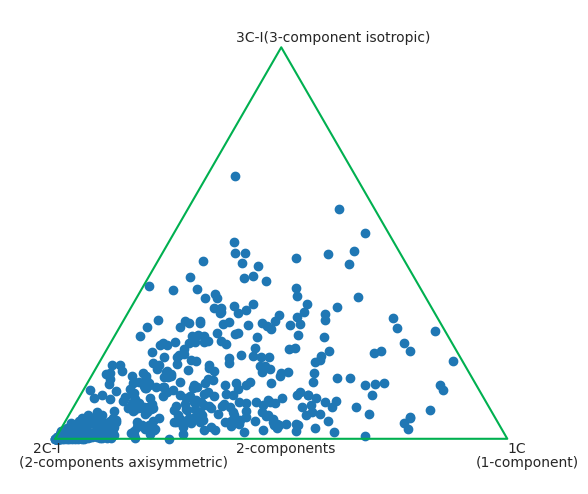

In [27]:
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
plt.close('all')
# coordinates of three vortices
x=np.array([0,1,0.5,0])
y=np.array([0,0,np.sqrt(3)/2,0])
# Figure and Axes
fig1=plt.figure(figsize=(7,7))
ax1=fig1.add_subplot(111)
# Plot Triangle 1 
ax1.axis('square')
plt.plot(x,y,color=[0/255,176/255,80/255])
# Axes Limits
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,0.95])
plt.text(-0.05,-0.03,'2C-I')
plt.text(-0.08,-0.06,'(2-components axisymmetric)')
plt.text(0.4,-0.03,'2-components')
plt.text(1, -0.03,'1C')
plt.text(0.93, -0.06,'(1-component)')
plt.text(0.4, 0.88,'3C-I(3-component isotropic)')
plt.axis("off")
# plt.scatter(cart_coord[::60,0],cart_coord[::60,1]) #true data
# plt.savefig('triangle_iso_004.png',dpi=600 , bbox_inches='tight')
plt.scatter(cart_coord[::10,0],cart_coord[::10,1])   # pce data
plt.savefig('triangle_iso_004_pce.png',dpi=600 , bbox_inches='tight')